# Intercomparison Campaigns - Aggregated Data

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the usability of data from intercomparison campaigns, especially aggregated data. 

    Author: U. Voggenberger
    Date: 09.2020
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2020

In [9]:
%config IPCompleter.greedy=True

import pandas
import numpy as np
import datetime
import xarray as xr
import pickle 
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
import sys
sys.path.append('/home/srvx11/lehre/users/a1400070/CEUAS/CEUAS/public/cds-backend/code')
import cds_eua3 as eua
eua.logging_set_level(30)

In [10]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

## Accessing data directly via XArray:

We open the whole aggregated dataset to check for errors.

Aggregated datasets contains mean values of intercomparison campagne data and variables related to the process of building mean values:

    data.secondary_value:
    describes the number of single datasets which go into the meanvalue of the observed_variable.
    
    data.original_precision:
    describes the data's variance 

Those parameters aren't yet accessible through the Climate Data Store (CDS) front-end. 

In [11]:
# opening the datasets and converting to Pandas DataFrame:
data = xr.open_mfdataset('/raid60/scratch/leo/scratch/RI/Pangaea/nc/0-20200*.nc', group='observations_table', join='override')
da = data.to_dataframe()

In [12]:
# we have data for these days:
da.date_time.drop_duplicates()

index
b''   1987-05-01 12:00:00
b''   1987-05-01 00:00:00
Name: date_time, dtype: datetime64[ns]

## Selecting Data Correctly:

We now have to select the right data to plot it and check for errors.

Iterating over each day will give us data of one comparison campagne.
In every day dataset, there are mean values of each sonde type. Those haven been processed to the differences between every sensor and a chosen reference sonde.
We iterate over each of those reference sondes to get every possible comparison. 
 

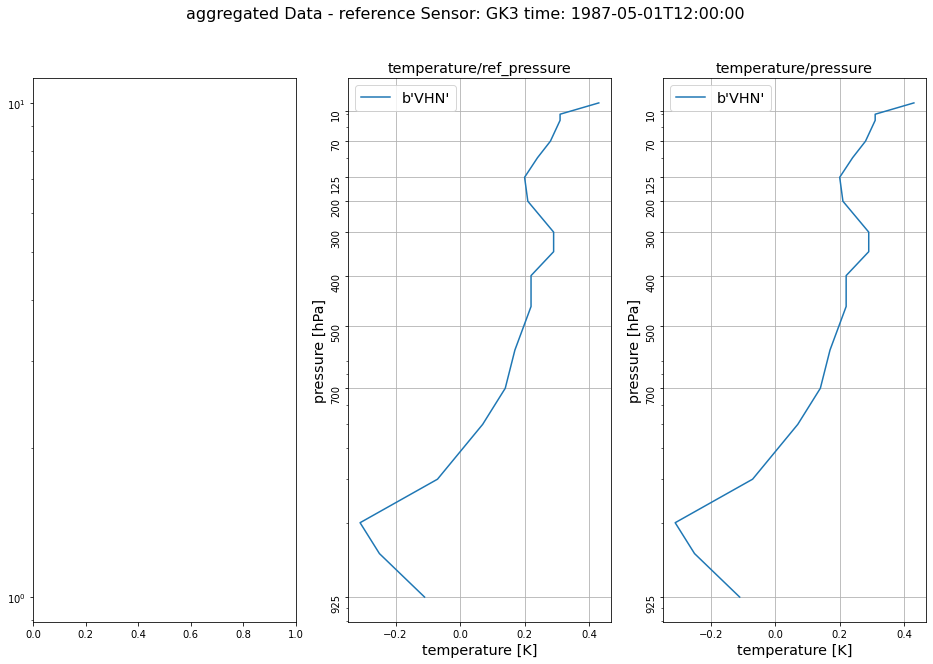

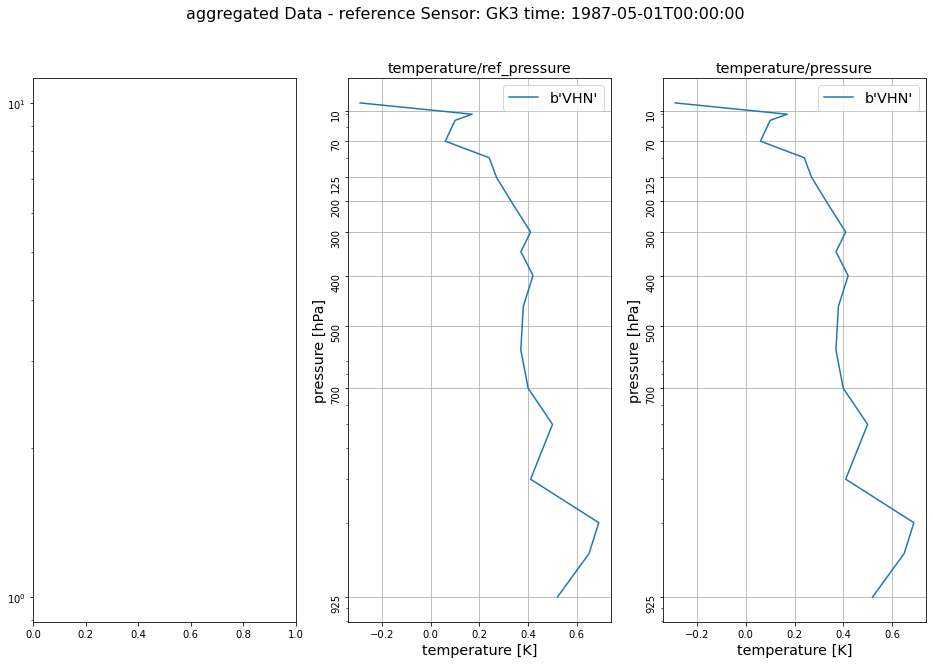

In [13]:
for i in da.date_time.drop_duplicates():
    a = da[da.date_time == i]
    for n in a.reference_sensor_id.drop_duplicates():
        b = a[a.reference_sensor_id == n]
        pres = []
        refpres = []
        temp = []
        geop = []
        #
        # get data of each available sonde:
        #
        for j in b.sensor_id.drop_duplicates():
            buffer = b[b.sensor_id == j]
            pres.append(buffer[buffer.observed_variable == 85].z_coordinate)
            refpres.append(buffer[buffer.observed_variable == 85].reference_z_coordinate)
            temp.append(buffer[buffer.observed_variable == 85].observation_value)
            geop.append(buffer[buffer.observed_variable == 117].observation_value)

        yplevs = np.array([10,70,125,200,300,400,500,700,925])*100.
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        #
        # Plotting geopotential over pressure: 
        #
        try:
            for i in range(len(temp)):
                ax1.semilogy(np.array(geop[i]), np.array(pres[i]))
            ax1.set(xlabel ='geopotential [m]', ylabel='pressure [hPa]', title='geopotential/pressure')
            ax1.legend(b.sensor_id.drop_duplicates(), loc='best')
            ax1.set_yticks(ticks=yplevs)
            ax1.set_yticklabels(map("{:.0f}".format,yplevs[::-1]/100),rotation='vertical')
            ax1.grid()
        except:
            # geopotential is not available for every dataset
            pass
        #
        # Plotting pressure over temperature: reference
        #
        for i in range(len(temp)):
            ax2.semilogy(np.array(temp[i]), np.array(refpres[i]))
        ax2.set(xlabel ='temperature [K]', ylabel='pressure [hPa]', title='temperature/ref_pressure')
        ax2.legend(b.sensor_id.drop_duplicates(), loc='best')
        ax2.set_yticks(ticks=yplevs)
        ax2.set_yticklabels(map("{:.0f}".format,yplevs[::-1]/100),rotation='vertical')
        ax2.grid()
        #
        # Plotting pressure over temperature: original
        #
        for i in range(len(temp)):
            ax3.semilogy(np.array(temp[i]), np.array(pres[i]))
        ax3.set(xlabel ='temperature [K]', ylabel='pressure [hPa]', title='temperature/pressure')
        ax3.legend(b.sensor_id.drop_duplicates(), loc='best')
        ax3.set_yticks(ticks=yplevs)
        ax3.set_yticklabels(map("{:.0f}".format,yplevs[::-1]/100),rotation='vertical')
        ax3.grid()
        #     -
        fig.suptitle('aggregated Data - reference Sensor: '+ n.decode() + ' time: ' + str(buffer.date_time.drop_duplicates().values)[2:21], fontsize=16)
        plt.show()
        plt.close(fig)
        #

    

## Checking for additional information

No errors occurred and every bit of information could be plotted.

Now we check for:
    
    data.units
    data.secondary_value
    data.original_precision


### Units
There are no unused units, and the listed ones are appropiate for the data.

    806	joules per kilogram	J/kg	NULL
    032	pascal	Pa	kg m-1 s-2
    005	kelvin	K	NULL
    110	degree (angle)	deg	NULL
    731	metres per second	m/s	NULL

In [6]:
da.units.drop_duplicates()
# 032	pascal	Pa	kg m-1 s-2

index
b''    806
b''      5
Name: units, dtype: int64

### Secondary Value
17 to 22 individual profiles were used to create the mean values.

In [7]:
da.secondary_value.drop_duplicates()
# number of ascents used to build mean value

index
b''    18.0
b''    19.0
b''    22.0
b''    17.0
b''    21.0
Name: secondary_value, dtype: float64

### Observed Variable
Each mean value has an attached variance.

In [8]:
a = da[da.observed_variable == 85]
print(a.original_precision)
b = da[da.observed_variable == 117]
print(b.original_precision)


# variance of the observed_variable

index
b''    0.35
b''    0.22
b''    0.17
b''    0.13
b''    0.09
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.07
b''    0.18
b''    0.34
b''    0.20
b''    0.17
b''    0.13
b''    0.10
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.06
b''    0.15
Name: original_precision, dtype: float64
index
b''    9.0
b''    7.0
b''    5.0
b''    4.0
b''    3.0
b''    3.0
b''    3.0
b''    2.0
b''    2.0
b''    2.0
b''    2.0
b''    2.0
b''    1.0
b''    1.0
b''    1.0
b''    1.0
b''    9.0
b''    7.0
b''    5.0
b''    4.0
b''    3.0
b''    3.0
b''    2.0
b''    2.0
b''    2.0
b''    2.0
b''    1.0
b''    1.0
b''    1.0
b''    1.0
b''    1.0
b''    1.0
Name: original_precision, dtype: float64
